In [17]:
import struct
import os
import h5py
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from __future__ import print_function
#from keras.models import load_model
metadata_type = np.dtype([("plaintext", np.uint8, (16,)),
                          ("key", np.uint8, (16,)),
                          ("ciphertext", np.uint8, (16,))
                          ])

def check_file_exists(file_path):
    if os.path.exists(file_path) == False:
        print("Error: provided file path '%s' does not exist!" % file_path)
        sys.exit(-1)
    return

In [2]:
def Inspector46_trs2h5(filename,outfile):
    trsfile = open(filename,"rb")
    j=0
    hl=128
    data_length=0
    while j<hl:
        data = trsfile.read(1)
        tag = int(data.encode('hex'),16)
        assert tag in range(0x41,0x5F)
        if tag ==0x41:#number of traces
            l=int(trsfile.read(1).encode('hex'),16) # length of value in byte
            data = trsfile.read(l)
            traces_num=int(data.encode('hex').decode('hex')[::-1].encode('hex_codec'),16)
            print('trace_num'+ str(traces_num))

        if tag ==0x42: #trace length
            l=int(trsfile.read(1).encode('hex'),16)
            data = trsfile.read(l)
            trace_length = int(data.encode('hex').decode('hex')[::-1].encode('hex_codec'),16)
            print('trace_length' + str(trace_length))

        if tag==0x43: #sample coding
            l=int(trsfile.read(1).encode('hex'),16)
            assert l==0x01
            data = trsfile.read(l)
            samp_coding = int(data.encode('hex'),16)
            assert samp_coding in [0x01,0x02,0x04,0x11,0x12,0x14]

        if tag==0x44: #data length
            l=int(trsfile.read(1).encode('hex'),16)
            data = trsfile.read(l)
            data_length = int(data.encode('hex').decode('hex')[::-1].encode('hex_codec'),16)
            assert data_length ==32 or data_length == 48
            print('data_length' + str(data_length))

        if tag in range(0x45,0x5F):# ignored information
            l=int(trsfile.read(1).encode('hex'),16)
            data = trsfile.read(l)

        if tag == 0x5F: #trace length
            assert int(trsfile.read(1).encode('hex'),16) == 0x00

            print('end of header')
            break

        j=j+1
    h5f = h5py.File(outfile,'w')

    metadata = []
    traces = []
    for i in range(traces_num):
    #for i in range(100):

        #print(i)
        #process crypt data
        key=np.zeros(shape=(16,),dtype=np.uint8)
        plaintext=[]
        ciphertext=[]
        #the data are in order: plaintext, ciphertext, key.
        #should be in accordence to h52trs
        if data_length != 0:
            for p in range(16):
                plaintext.append(np.int8(int(trsfile.read(1).encode('hex'),16)))
            for c in range(16):
                ciphertext.append(np.int8(int(trsfile.read(1).encode('hex'),16)))
            if data_length==48:
                for k in range(16):
                    key[k]=np.int8(int(trsfile.read(1).encode('hex'),16))
        one_metadata=np.array((plaintext,key,ciphertext),dtype=metadata_type)
        metadata.append(one_metadata)

        #process trace points
        one_trace_list=[]
        for pnt in range(trace_length):
            if (samp_coding==0x01):
                one_trace_list.append(np.int8(int(trsfile.read(1).encode('hex'),16)))
            if (samp_coding==0x14):
                s1=trsfile.read(1)
                s2=trsfile.read(1)
                s3=trsfile.read(1)
                s4=trsfile.read(1)
                s=s4+s3+s2+s1
                one_trace_list.append(np.float(struct.unpack('!f',s)[0]))
        if (samp_coding==0x01):
            one_trace=np.array(one_trace_list,dtype=np.int8)
        if (samp_coding==0x14):
            one_trace=np.array(one_trace_list,dtype=np.float)

        traces.append(one_trace)

    h5f.create_dataset('metadata',data = metadata)
    h5f.create_dataset('traces',data = traces)
    h5f.flush()
    h5f.close()

In [32]:
def Inspector411_trs2h5(filename,outfile):
    trsfile = open(filename,"rb")
    j=0
    hl=256
    data_length=0
    while j<hl:
        data = trsfile.read(1)
        tag = int(data.encode('hex'),16)
        try:
            assert tag in range(0x41,0x70)
        except AssertionError: 
            print(hex(tag))
            sys.exit(-1)
            
        if tag ==0x41:#number of traces
            l=int(trsfile.read(1).encode('hex'),16) # length of value in byte
            data = trsfile.read(l)
            traces_num=int(data.encode('hex').decode('hex')[::-1].encode('hex_codec'),16)
            print('trace_num '+ str(traces_num))

        if tag ==0x42: #trace length
            l=int(trsfile.read(1).encode('hex'),16)
            data = trsfile.read(l)
            trace_length = int(data.encode('hex').decode('hex')[::-1].encode('hex_codec'),16)
            print('trace_length ' + str(trace_length))

        if tag==0x43: #sample coding
            l=int(trsfile.read(1).encode('hex'),16)
            assert l==0x01
            data = trsfile.read(l)
            samp_coding = int(data.encode('hex'),16)
            assert samp_coding in [0x01,0x02,0x04,0x11,0x12,0x14]

        if tag==0x44: #data length
            l=int(trsfile.read(1).encode('hex'),16)
            data = trsfile.read(l)
            data_length = int(data.encode('hex').decode('hex')[::-1].encode('hex_codec'),16)
            assert data_length in [0,32,48,16,24]
            print('data_length ' + str(data_length))
            
        if tag==0x45: #title space reserved per trace
            l=int(trsfile.read(1).encode('hex'),16)
            assert l==1
            data = trsfile.read(l)
            titlspclen=int(data.encode('hex'),16)
            print('title space reserved for each trace ' + str(titlspclen))
            
        if (tag in range(0x46, 0x5F)) or (tag in range(0x60, 0x70)):# ignored information
            l=int(trsfile.read(1).encode('hex'),16)
            data = trsfile.read(l)

        if tag == 0x5F: #trace length
            assert int(trsfile.read(1).encode('hex'),16) == 0x00

            print('end of header')
            break

        j=j+1
    try:
        h5f = h5py.File(outfile,'w')
    except IOError:
        os.remove(outfile)
        h5f = h5py.File(outfile,'w')

    metadata = []
    traces = []
    for i in range(traces_num):
    #for i in range(100):
        #print(i)
        #title space reserved per trace
        trsfile.read(titlspclen)
        #process crypt data
        key=np.zeros(shape=(16,),dtype=np.uint8)
        plaintext=np.zeros(shape=(16,),dtype=np.uint8)
        ciphertext=np.zeros(shape=(16,),dtype=np.uint8)
        
        #the data are in order: plaintext, ciphertext, key.
        #should be in accordence to acquisition
        if data_length in [32,48]: #for AES and SM4
            for p in range(16):
                plaintext[p]=np.int8(int(trsfile.read(1).encode('hex'),16))
                
            for c in range(16):
                ciphertext[c]=np.int8(int(trsfile.read(1).encode('hex'),16))
                
            if data_length==48:
                for k in range(16):
                    key[k]=np.int8(int(trsfile.read(1).encode('hex'),16))
                    
        elif data_length in [16,24]: #for DES
            for p in range(8):
                plaintext[p]=np.int8(int(trsfile.read(1).encode('hex'),16))
            
            for c in range(8):
                ciphertext[c]=np.int8(int(trsfile.read(1).encode('hex'),16))
            
            if data_length==24:
                for k in range(8):
                    key[k]=np.int8(int(trsfile.read(1).encode('hex'),16))
        one_metadata=np.array((plaintext,key,ciphertext),dtype=metadata_type)
        metadata.append(one_metadata)

        #process trace points
        one_trace_list=[]
        for pnt in range(trace_length):
            if (samp_coding==0x01):
                one_trace_list.append(np.int8(int(trsfile.read(1).encode('hex'),16)))
            if (samp_coding==0x14):
                s1=trsfile.read(1)
                s2=trsfile.read(1)
                s3=trsfile.read(1)
                s4=trsfile.read(1)
                s=s4+s3+s2+s1
                one_trace_list.append(np.float(struct.unpack('!f',s)[0]))
        if (samp_coding==0x01):
            one_trace=np.array(one_trace_list,dtype=np.int8)
        if (samp_coding==0x14):
            one_trace=np.array(one_trace_list,dtype=np.float)

        traces.append(one_trace)

    h5f.create_dataset('metadata',data = metadata)
    h5f.create_dataset('traces',data = traces)
    h5f.flush()
    h5f.close()

/metadata
(100,)
[('plaintext', 'u1', (16,)), ('key', 'u1', (16,)), ('ciphertext', 'u1', (16,))]
/traces
(100, 298106)
int8
plaintext [  4  76 224   1  59  68  48  66   0   0   0   0   0   0   0   0]
key[ 17  34  51  68  85 102 119 136   0   0   0   0   0   0   0   0]
ciphertext [ 16  14 174 107 178 194 117 101   0   0   0   0   0   0   0   0]


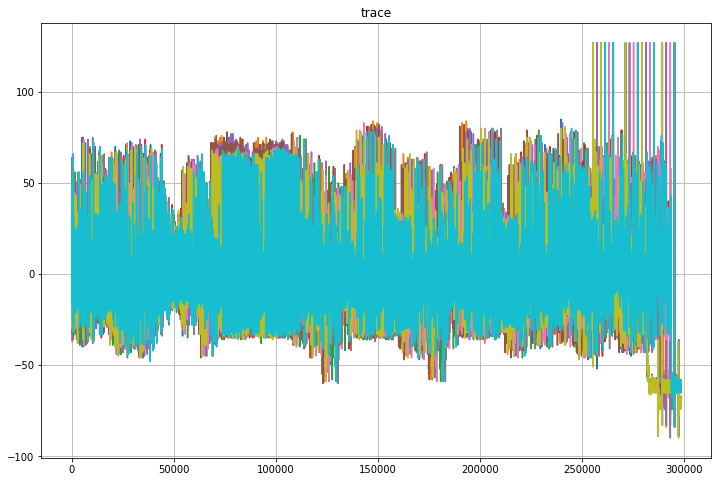

In [34]:
in_file='../tongfang/DES_attack_100 + Trim.trs'
out_file='../tongfang/DES_attack_100 + Trim.h5'
#Inspector411_trs2h5(in_file,out_file)
f=h5py.File(out_file,'r')

for key in ['metadata','traces']:
    print(f[key].name)
    print(f[key].shape)
    #print(f[key].value)
    print(f[key].dtype)
t=f['traces']
#for i in range(20):
#    print(t[0][i])
print('plaintext '+str(f['metadata'][0]['plaintext']))
print('key' + str(f['metadata'][0]['key']))
print('ciphertext '+str(f['metadata'][0]['ciphertext']))


i=0
plt.rcParams['figure.figsize']=(12,8) 
for t in f['traces']:
    if i < 10:
        plt.title('trace')
        #plt.xlabel('number of traces')
        #plt.ylabel('rank')
        plt.grid(True)
        plt.plot(t)
        i=i+1
    else:
        break

plt.show()
#plt.figure()


f.close()

In [3]:
def temp_cls_ANOVA_key(traces,kbyte_index,key): 
    num_samp = len(traces[0])
    num_trs = len(traces)
    avr = [[0.0 for s in range(num_samp)] for i in range(256)]
    avr=np.array(avr)
    num_each_cls = [0 for i in range(256)]
    point_index=[j for j in range(num_samp)]
    for i in range(len(traces)):
        #print(i,end=' ')
        k = key[i][kbyte_index]
        num_each_cls[k]=num_each_cls[k]+1
        
        avr[k]=avr[k] + traces[i][point_index]
        
    assert np.array(num_each_cls).sum()==num_trs
    for i in range(256):
        
        avr[i]=avr[i]/num_each_cls[i]
    
    
    avr_sum = np.array([0.0 for i in range(num_samp)])
    square_sum = np.array([0.0 for i in range(num_samp)])
    for i in range(num_samp):
        avr_sum[i]=avr[:,i].sum()
        square_sum[i]=(avr[:,i]**2).sum()
    
    var=square_sum/256-(avr_sum/256)**2
    return (avr,var)

In [ ]:

h5file=h5py.File(out_file,'r')
traces=h5file['traces']
keys=h5file['metadata']['key']
print(traces[0])
print(keys[15])
(avr,var)=temp_cls_ANOVA_key(traces,15,keys)

for t in avr:        
    plt.plot(t)
plt.title('Average in each class')
plt.grid(True)
plt.rcParams['figure.figsize']=(20,8)   
plt.show()
plt.figure()

plt.plot(var)
plt.title('Variance of each class')
plt.grid(True)
plt.rcParams['figure.figsize']=(20,8)   
plt.show()
plt.figure()

In [4]:
def target_points(var,threshold):
    res = []
    for i in range(len(var)):
        if var[i]>threshold:
            res.append(i)
    return res
def target_points_top(var,num):
    res = []
    var_list=list(var)
    temp_list=list(var)
    temp_list.sort(reverse=True)
    
    for i in range(num):
        res.append(var_list.index(temp_list[i]))
    res.sort()
    return res

In [ ]:
tar=target_points(var,0.5)
print(len(tar))


In [5]:
def temp_labelize(keys,keybyte_index):
    return keys[:, keybyte_index]
def temp_extract_traces(traces_file, labeled_traces_file,profiling_index,attack_index, target_points,keybyte_index):
    #check_file_exists(traces_file)
    #check_file_exists(os.path.dirname(labeled_traces_file))
    # Open the raw traces HDF5 for reading
    try:
        in_file  = h5py.File(traces_file, "r")
    except:
        print("Error: can't open HDF5 file '%s' for reading (it might be malformed) ..." % traces_file)
        sys.exit(-1)
        
    # Open the output labeled file for writing
    try:
        out_file = h5py.File(labeled_traces_file, "w")
    except:
        print("Error: can't open HDF5 file '%s' for writing ..." % labeled_traces_file)
        sys.exit(-1)
        
    raw_traces = in_file['traces']
    raw_plaintexts = in_file['metadata']['plaintext']
    raw_ciphertexts = in_file['metadata']['ciphertext']
    raw_keys = in_file['metadata']['key']
    
    raw_traces_profiling = np.zeros([len(profiling_index), len(target_points)], raw_traces.dtype)
    current_trace=0
    
    for t in profiling_index:       
        print(t,end=' ')
        
        raw_traces_profiling[current_trace]=raw_traces[t,target_points]
            
        current_trace = current_trace+1    
    
    print(raw_traces_profiling.shape)
    
    raw_traces_attack = np.zeros([len(attack_index), len(target_points)], raw_traces.dtype)
    current_trace=0
    for t in attack_index:       
        
        raw_traces_attack[current_trace]=raw_traces[t,target_points]
        current_trace = current_trace+1    
    
    print(raw_traces_attack.shape)
    
    
    # Compute our labels
    labels_profiling = temp_labelize(raw_keys[profiling_index], keybyte_index)
    labels_attack  = temp_labelize(raw_keys[attack_index], keybyte_index)
    
    # Create our HDF5 hierarchy in the output file:
    # 	- Profilinging traces with their labels
    #	- Attack traces with their labels
    profiling_traces_group = out_file.create_group("Profiling_traces")
    attack_traces_group = out_file.create_group("Attack_traces")
    # Datasets in the groups
    profiling_traces_group.create_dataset(name="traces", data=raw_traces_profiling, 
                                          dtype=raw_traces_profiling.dtype)
    attack_traces_group.create_dataset(name="traces", data=raw_traces_attack, dtype=raw_traces_attack.dtype)
    # Labels in the groups
    profiling_traces_group.create_dataset(name="labels", data=labels_profiling, dtype=labels_profiling.dtype)
    attack_traces_group.create_dataset(name="labels", data=labels_attack, dtype=labels_attack.dtype)
    # Put the metadata (plaintexts, keys, ...) so that one can check the key rank
   
    profiling_metadata = np.array([(raw_plaintexts[n], raw_keys[n], raw_ciphertexts[n]) for n in profiling_index], 
                                  dtype=metadata_type)
    profiling_traces_group.create_dataset("metadata", data=profiling_metadata, dtype=metadata_type)
    attack_metadata = np.array([(raw_plaintexts[n], raw_keys[n], raw_ciphertexts[n]) for n in attack_index], 
                               dtype=metadata_type)
    attack_traces_group.create_dataset("metadata", data=attack_metadata, dtype=metadata_type)

    out_file.flush()
    out_file.close()


In [ ]:
labeled_out_file=' '


temp_extract_traces(out_file,labeled_out_file,[i for i in range(249505)],[i for i in range(259505-5000,259504)],tar,12)


In [6]:
from keras.models import Model, Sequential
from keras.layers import core, Flatten, Dense, Input, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.models import load_model

def load_data(file, load_metadata=False):
    #check_file_exists(file)
    # Open the database HDF5 for reading
    try:
        in_file  = h5py.File(file, "r")
    except:
        print("Error: can't open HDF5 file '%s' for reading (it might be malformed) ..." % file)
        sys.exit(-1)
    # Load profiling traces
    X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
    # Load profiling labels
    Y_profiling = np.array(in_file['Profiling_traces/labels'])
    # Load attacking traces
    X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
    # Load attacking labels
    Y_attack = np.array(in_file['Attack_traces/labels'])
    if load_metadata == False:
        return (X_profiling, Y_profiling), (X_attack, Y_attack)
    else:
        return (X_profiling, Y_profiling), (X_attack, Y_attack), (in_file['Profiling_traces/metadata'], 
                                                                  in_file['Attack_traces/metadata'])

    #### Training high level function
def train_model(X_profiling, Y_profiling, model, save_file_name,set_validation_split=0.05,
                set_batch_size=128, set_verbose = 1, set_epochs=30):
   # check_file_exists(os.path.dirname(save_file_name))
    # Save model every epoch
    save_model = ModelCheckpoint(save_file_name)
    callbacks=[save_model]
    # Get the input layer shape
    input_layer_shape = model.get_layer(index=0).input_shape
    # Sanity check
    if input_layer_shape[1] != len(X_profiling[0]):
        print("Error: model input shape %d instead of %d is not expected ..." % (input_layer_shape[1],
                                                                                 len(X_profiling[0])))
        sys.exit(-1)
    # Adapt the data shape according our model input
    if len(input_layer_shape) == 2:
        # This is a MLP
        Reshaped_X_profiling = X_profiling
    elif len(input_layer_shape) == 3:
        # This is a CNN: expand the dimensions
        Reshaped_X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
    else:
        print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
        sys.exit(-1)

    history = model.fit(x=Reshaped_X_profiling, y=to_categorical(Y_profiling, num_classes=256),validation_split=set_validation_split,
                        batch_size=set_batch_size, verbose=set_verbose, epochs=set_epochs, callbacks=callbacks)
    
    return history
def plot(history,width=18,height=6):
    plt.rcParams['figure.figsize']=(width,height)   
    # summarize history for accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.show()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Using TensorFlow backend.


In [ ]:
#labeled_out_file='SM4KeyLoading_DeepLearning_labeled.h5'
(X_profiling, Y_profiling), (X_attack, Y_attack), (Profiling_metadata, Attack_metadata) = load_data(labeled_out_file,True)

#### MLP  model
def mlp(set_input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=set_input_dim, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='softmax'))
    optimizer = RMSprop(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
mlp_model = mlp(len(X_profiling[0]))

###CNN model
def cnn(trace_length):
    input_shape = (trace_length,1)
    trace_input = Input(shape=input_shape)
    
    #Block1
    x = Conv1D(8,kernel_size=10, activation='relu',padding='same',name='block1_conv1')(trace_input)
    x = MaxPooling1D(2, strides=2, name='block1_pool')(x)
    
    #Block2
    x = Conv1D(32, 1, activation = 'relu', padding='same',name='block2_conv1')(x)
    x = MaxPooling1D(2, strides=2, name='block2_pool')(x)
    
    #if drop_out:
    #    x = Dropout(drop_out)(x)
    # Classification block
    x = Flatten(name='flatten')(x)
    
    #x = Dense(512, activation='relu', name='fc1')(x)
    x = Dense(256, activation='softmax', name='predictions')(x)
    
    inputs = trace_input
    model = Model(inputs, x,name='cnn')
    optimizer = RMSprop(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
cnn_model = cnn(len(X_profiling[0]))

trained_model='SM4KeyLoading_DeepLearning_model.h5'
history=train_model(X_profiling, Y_profiling, mlp_model, trained_model,set_validation_split=0.2,set_batch_size=512,
                    set_verbose=1,set_epochs=30)
plot(history,12,5)


In [3]:
# Compute the prob of the key candidates for a give set of predictions
def prob_sum(predictions, min_trace_idx, max_trace_idx, last_key_bytes_proba):
    # Compute the rank
    if len(last_key_bytes_proba) == 0:
        # If this is the first rank we compute, initialize all the estimates to zero
        key_bytes_proba = np.zeros(256)
    else:
        # This is not the first rank we compute: we optimize things by using the
        # previous computations to save time!
        key_bytes_proba = last_key_bytes_proba

    for p in range(0, max_trace_idx-min_trace_idx):
        # Go back from the class to the key byte. '2' is the index of the byte (third byte) of interest.
        #plaintext = metadata[min_trace_idx + p]['plaintext'][S_index]
        for i in range(0, 256):
            # Our candidate key byte probability is the sum of the predictions logs
            proba = predictions[p][i]
            
            key_bytes_proba[i] += proba
        
       
    return key_bytes_proba

# Compute the prob of the first round subkey candidates of DES for a give set of predictions
def DES_prob_sum(inverseS, predictions, metadata, min_trace_idx, max_trace_idx, last_key_bytes_proba, S_index):
    # Compute the rank
    if len(last_key_bytes_proba) == 0:
        # If this is the first rank we compute, initialize all the estimates to zero
        key_bytes_proba = np.zeros(64)
    else:
        # This is not the first rank we compute: we optimize things by using the
        # previous computations to save time!
        key_bytes_proba = last_key_bytes_proba

    for p in range(0, max_trace_idx-min_trace_idx):
        # Go back from the class to the subkey byte.
        block = mydes.__int_to_BitList(metadata[min_trace_idx + p]['plaintext'][:8])
        block = mydes.__permutate(mydes.__ip, block)
        R = block[32:]
        R_byte = mydes.__SixBitList_to_int(R[S_index*6:S_index*6+6])
        
        for i in range(0, 64):
            # Our candidate subkey byte probability is the sum of the predictions
            proba = predictions[p][i]
            for j in range(4):
                subkey = R_byte ^ inverseS[S_index][i][j]
                key_bytes_proba[subkey] += proba
        
       
    return key_bytes_proba
def full_probs(model_file, dataset, min_trace_idx, max_trace_idx, rank_step):
    check_file_exists(model_file)
    try:
        model = load_model(model_file)
    except:
        print("Error: can't load Keras model file '%s'" % model_file)
        sys.exit(-1)
    # Check for overflow
    if max_trace_idx > dataset.shape[0]:
        print("Error: asked trace index %d overflows the total traces number %d" % (max_trace_idx, dataset.shape[0]))
        sys.exit(-1)
    # Get the input layer shape
    input_layer_shape = model.get_layer(index=0).input_shape
    # Sanity check
    if input_layer_shape[1] != len(dataset[0, :]):
        print("Error: model input shape %d instead of %d is not expected ..." % (input_layer_shape[1], len(dataset[0, :])))
        sys.exit(-1)
    # Adapt the data shape according our model input
    if len(input_layer_shape) == 2:
        # This is a MLP
        input_data = dataset[min_trace_idx:max_trace_idx, :]
    elif len(input_layer_shape) == 3:
        # This is a CNN: reshape the data
        input_data = dataset[min_trace_idx:max_trace_idx, :]
        input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
    else:
        print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
        sys.exit(-1)

    # Predict our probabilities
    predictions = model.predict(input_data)

    index = np.arange(min_trace_idx+rank_step, max_trace_idx, rank_step)
    f_probs = np.zeros((256, len(index)), dtype=np.float16)
    key_bytes_proba = []
    for t, i in zip(index, range(0, len(index))):
        key_bytes_proba = prob_sum(predictions[t-rank_step:t], t-rank_step, t, key_bytes_proba)
        num_pred_trs = (i+1)*rank_step
        #print(num_pred_trs)
        f_probs[:,i]=key_bytes_proba/num_pred_trs
    plt.rcParams['figure.figsize']=(12,5) 
    for i in range(256):    
        plt.plot(index,f_probs[i])
        #print(f_probs[i])
    plt.show()
    pred_key=np.where(key_bytes_proba==max(key_bytes_proba))[0][0]
    
    #pred_key=np.where(key_bytes_proba==(key_bytes_proba))[0][0]
    #print(hex(pred_key))
    return (pred_key,key_bytes_proba)
def pred_top(key_bytes_proba,n):
    res=[]
    sorted_key_bytes_proba=sorted(key_bytes_proba,reverse=True)
    for i in range(n):
        temp=np.where(key_bytes_proba==sorted_key_bytes_proba[i])
        assert len(temp[0])==1
        res.append([temp[0][0],sorted_key_bytes_proba[i]])
    return res

In [ ]:
labeled_out_file='SM4KeyLoading_DeepLearning_labeled.h5'
(X_profiling, Y_profiling), (X_attack, Y_attack), (Profiling_metadata, Attack_metadata) = load_data(labeled_out_file,True)

trained_model='SM4KeyLoading_DeepLearning_model.h5'
(f_probs,key_bytes_proba)=full_probs(trained_model,X_attack,0,4999,1)
print(hex(f_probs))

print(key_bytes_proba)
for i in pred_top(key_bytes_proba,256):
    print(hex(i))


In [1]:
from mydes import *
from __future__ import print_function
key=[0x0f,0x15,0x71,0xc9,0x47,0xd9,0xe8,0x59]
plaintext=[0x02,0x46,0x8a,0xce,0xec,0xa8,0x64,0x20]
#D=mydes()
cyph=mydes.crypt(plaintext,key,0)
sout=mydes.des_getIntermediateValue(plaintext,key,0)
for i in range(8):
    print(hex(sout[i]),end  = ' ')
print()
#for i in range(16):
#    print(D.Kn[i])
for i in range(8):
    print(hex(cyph[0][i]),end=' ')
    
InverseS=mydes.inverse_Sbox()

0xa 0x3 0x2 0xf 0x1 0x1 0xc 0x2 
0xda 0x2 0xce 0x3a 0x89 0xec 0xac 0x3b 

In [3]:
InverseS[0]

[[1, 28, 59, 62],
 [6, 15, 34, 45],
 [8, 11, 39, 44],
 [16, 29, 53, 56],
 [2, 7, 32, 41],
 [24, 27, 49, 60],
 [19, 20, 42, 61],
 [5, 30, 47, 54],
 [14, 31, 37, 38],
 [25, 26, 43, 52],
 [17, 18, 57, 58],
 [12, 23, 46, 51],
 [21, 22, 35, 50],
 [4, 13, 40, 63],
 [0, 9, 36, 55],
 [3, 10, 33, 48]]